In [20]:
# import the libraries

import cv2
from imutils import paths
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import pathlib
import PIL
import random

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import GlobalAveragePooling2D, AveragePooling2D, Dropout, Flatten, Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import ResNet50
import tensorflow as tf
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras import layers


# Exploratory Data Analysis

In [18]:
#initializing model constants
INITIAL_LEARINGRATE = .001
EPOCHS = 30
BATCH_SIZE = 32
LENGTH = 224
WIDTH = 224

In [29]:
# images without covid
wOut_Covid = list(pathlib.Path("./DATA").glob('0/*'))

# images with covid
w_Covid = list(pathlib.Path("./DATA").glob('1/*'))

There are 1301 images without Covid
There are 1790 images without Covid


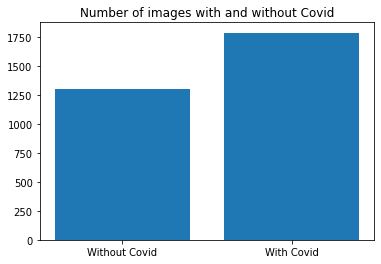

In [30]:
# number of images with and without covid

print('There are', len(wOut_Covid), 'images without Covid')
print('There are', len(w_Covid), 'images without Covid')

plt.bar(['Without Covid', 'With Covid'], [len(wOut_Covid), len(w_Covid)], align = 'center')
plt.title('Number of images with and without Covid')
plt.show()



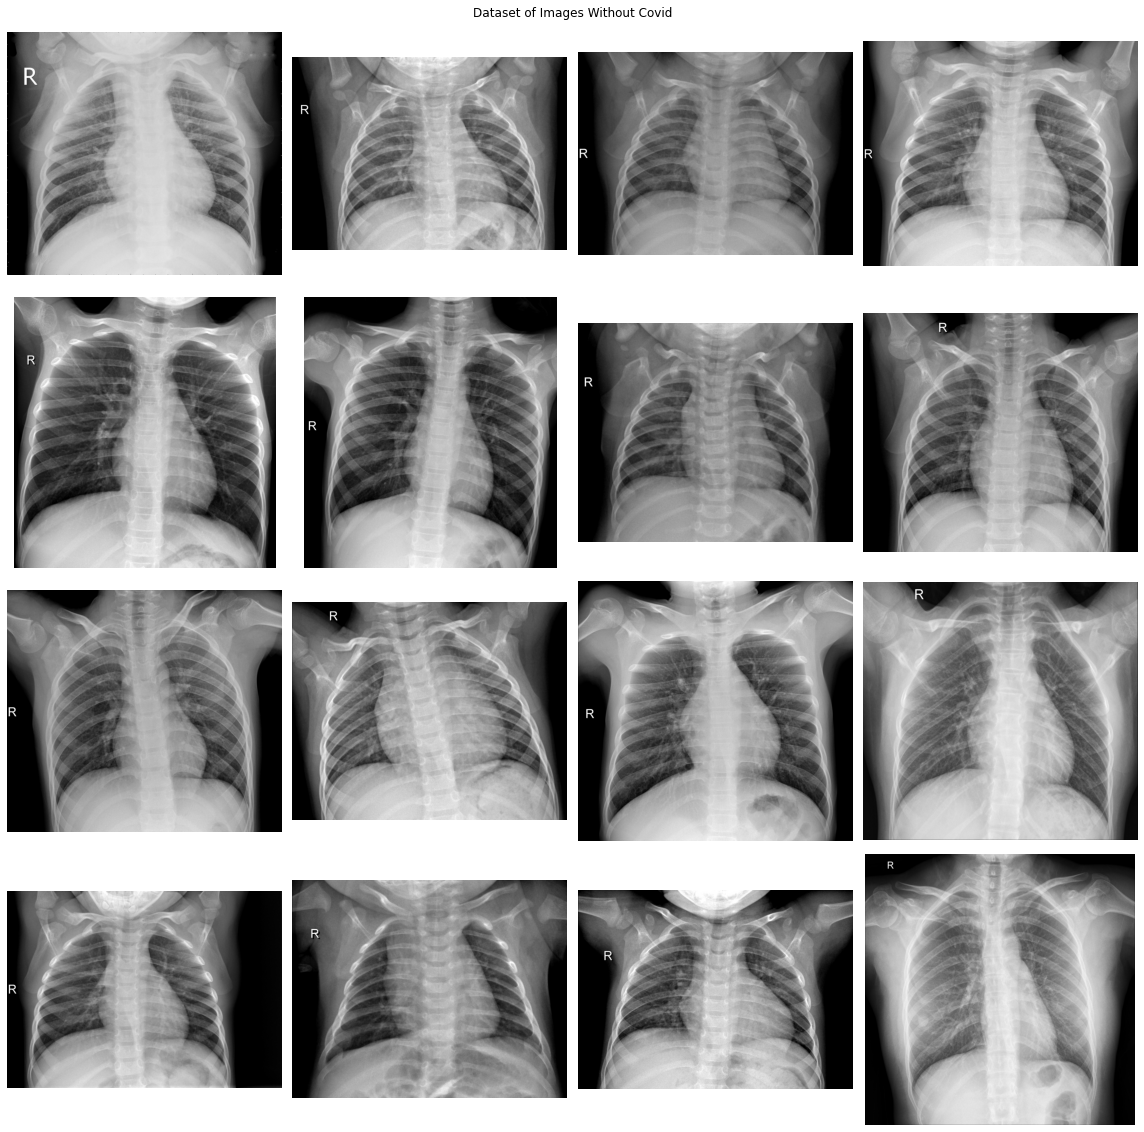

In [34]:
# grab the image path for the images without covid
image_dir = "./DATA/0/"

# create a 4x4 subplot
fig, axs = plt.subplots(4, 4, figsize=(16, 16))
axs = axs.ravel() # flatten the axes array

# get a list of all image files in the directory
image_files = [filename for filename in os.listdir(image_dir)]

# randomly select 16 images from the list
selected_files = random.sample(image_files, k=16)

# loop through the selected files
for i, filename in enumerate(selected_files):
    # load the image using matplotlib
    img = plt.imread(os.path.join(image_dir, filename))

    # display the image in the appropriate subplot
    axs[i].imshow(img.astype("uint8"))
    axs[i].axis('off')
     
# show the plot
plt.suptitle('Dataset of Images Without Covid')
plt.tight_layout()
plt.show() 

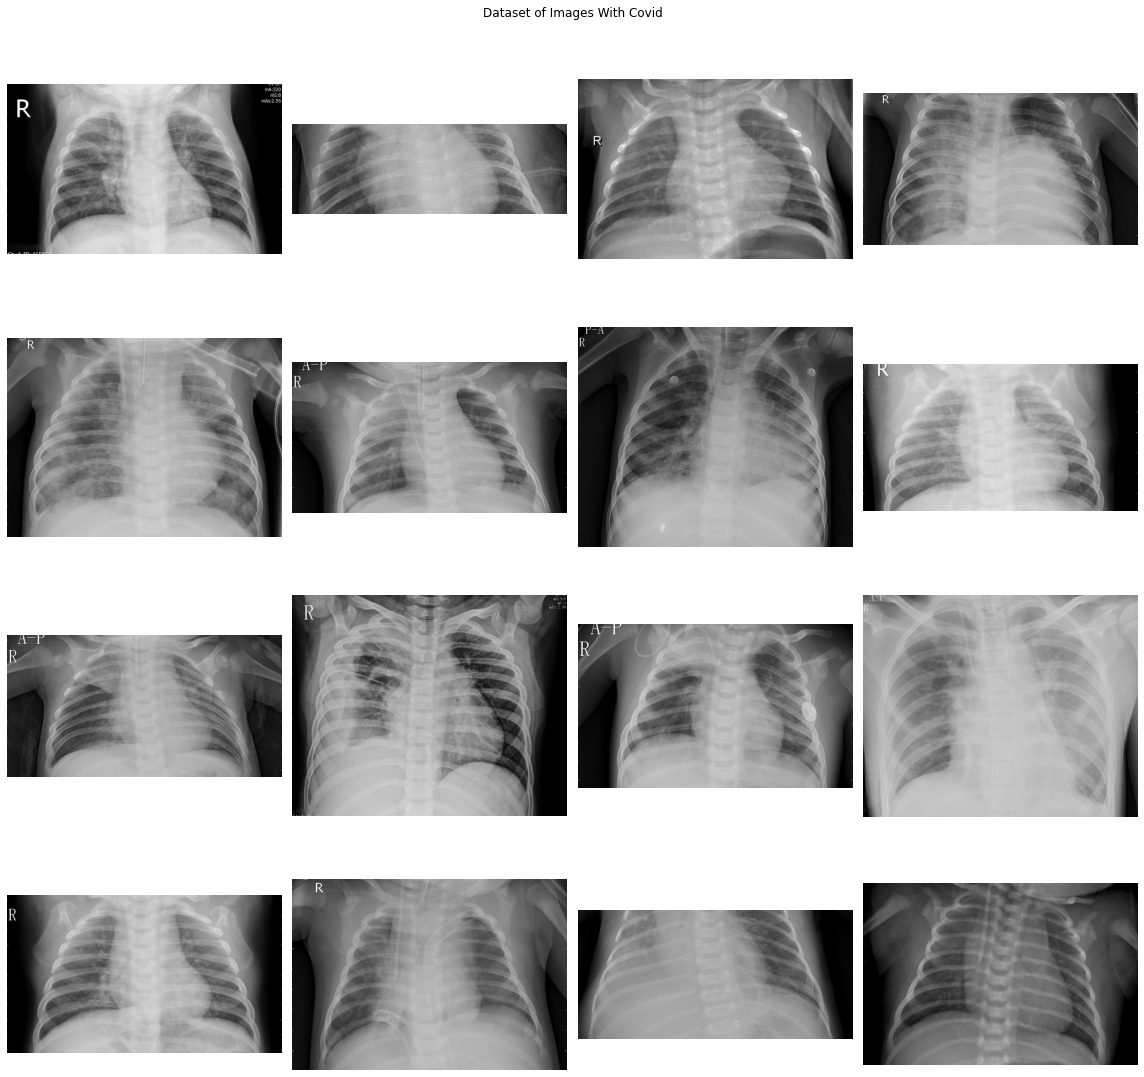

In [36]:
# grab the image path for the images with covid
image_dir = "./DATA/1/"

# create a 4x4 subplot
fig, axs = plt.subplots(4, 4, figsize=(16, 16))
axs = axs.ravel() # flatten the axes array

# get a list of all image files in the directory
image_files = [filename for filename in os.listdir(image_dir)]

# randomly select 16 images from the list
selected_files = random.sample(image_files, k=16)

# loop through the selected files
for i, filename in enumerate(selected_files):
    # load the image using matplotlib
    img = plt.imread(os.path.join(image_dir, filename))

    # display the image in the appropriate subplot
    axs[i].imshow(img.astype("uint8"))
    axs[i].axis('off')
     
# show the plot
plt.suptitle('Dataset of Images With Covid')
plt.tight_layout()
plt.show() 

# Preprocessing the Data

In [43]:
# take the images and put them into lists
image_path = list(paths.list_images(r"./DATA/"))
# create empty list for the data and the labels
data = list()
labels = list()

In [44]:
# now we want to loop over all the images in the files and then rescale them to a 224x224 aspect ratio. This will be done via the CV library
for x in image_path:
    # getting the classlabel
    label = x.split(os.path.sep)[-2]

    # now, we load the image, change the color to RGB and then resize it
    image = cv2.imread(x)
    image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    image = cv2.resize(image,(LENGTH,WIDTH))

    # update our label and data list
    labels.append(label)
    data.append(image)

In [45]:
# convert the data and labels to Numpy Arrays while scaling the pixel intensity
data = np.array(data) / 255.0 # 255 RGB colors
data.reshape(-1,1)
labels = np.array(labels)
data.shape

(3091, 224, 224, 3)

In [46]:
# one-hot encoding the models
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

In [47]:
# creating our train and test data. Using standard practice, 80% of the dataset will be used for training 
# while the 20% will be used for testing
trainX, testX, trainY, testY = train_test_split(data,labels,test_size=.2, stratify=labels,random_state=42)

In [48]:
# initialize the training data augmentation object
train_augment = ImageDataGenerator(
    rotation_range = 15,
    fill_mode = 'nearest'
)

train_augment_bis = ImageDataGenerator(
    rotation_range = 15,
    vertical_flip = True, 
    horizontal_flip = True,
    fill_mode = 'nearest'
)

# VGG16 Model

In [49]:
# load the base model
base_model = VGG16(weights="imagenet", include_top=False,input_tensor=Input(shape=(LENGTH,WIDTH,3)))

58900480/58889256 [==============================] - 1s 0us/step


In [50]:
# create the head of the model that is going to be on top of the base model
head_model = base_model.output
head_model = AveragePooling2D(pool_size=(4,4))(head_model)
head_model = Flatten(name='flatten')(head_model)
head_model = Dense(64, activation='relu')(head_model)
head_model = Dropout(0.5)(head_model)
head_model = Dense(2, activation='softmax')(head_model)

In [51]:
# now we will create our model; this model will be the one that is used to do the trainings
model = Model(inputs=base_model.input, outputs=head_model)

In [52]:
# freeze the layers of the base model so its not updated during the first training process
for y in base_model.layers:
    y.trainable = False

Compiling the Model

In [54]:
# using the ADAM optimizer to optimize
optimizer = Adam(learning_rate=INITIAL_LEARINGRATE, decay = INITIAL_LEARINGRATE/EPOCHS)

In [55]:
# compile the model
model.compile(
    optimizer = optimizer,
    loss = 'binary_crossentropy',
    metrics = ['accuracy']
)

Training the Network

In [56]:
# train the head of the network
head = model.fit(
    train_augment.flow(trainX,trainY,batch_size=BATCH_SIZE),
    steps_per_epoch = len(trainX)//BATCH_SIZE,
    validation_data = (testX,testY),
    validation_steps = len(testX) // BATCH_SIZE,
    epochs = EPOCHS
)

Epoch 1/30
77/77 [==============================] - 160s 2s/step - loss: 0.5732 - accuracy: 0.7221 - val_loss: 0.4208 - val_accuracy: 0.8562
Epoch 2/30
77/77 [==============================] - 161s 2s/step - loss: 0.3998 - accuracy: 0.8549 - val_loss: 0.3071 - val_accuracy: 0.8918
Epoch 3/30
77/77 [==============================] - 166s 2s/step - loss: 0.3215 - accuracy: 0.8844 - val_loss: 0.2719 - val_accuracy: 0.8869
Epoch 4/30
77/77 [==============================] - 166s 2s/step - loss: 0.2817 - accuracy: 0.8988 - val_loss: 0.2332 - val_accuracy: 0.9015
Epoch 5/30
77/77 [==============================] - 161s 2s/step - loss: 0.2584 - accuracy: 0.8975 - val_loss: 0.2099 - val_accuracy: 0.9128
Epoch 6/30
77/77 [==============================] - 160s 2s/step - loss: 0.2362 - accuracy: 0.9127 - val_loss: 0.1963 - val_accuracy: 0.9225
Epoch 7/30
77/77 [==============================] - 160s 2s/step - loss: 0.2352 - accuracy: 0.9127 - val_loss: 0.1950 - val_accuracy: 0.9321
Epoch 8/30
77

Making Predictions

In [57]:
# predicting using the trained model
predict = model.predict(testX,batch_size=BATCH_SIZE)

In [58]:
# for each image, find the index of the label corresponding with the largest predicted probability
predict = np.argmax(predict,axis=1)

In [59]:
# now represent the prediction in a nicely formatted classification report
print(classification_report(testY.argmax(axis=1),predict,target_names=lb.classes_))

              precision    recall  f1-score   support

    ./DATA/0       0.87      0.99      0.93       261
    ./DATA/1       0.99      0.89      0.94       358

    accuracy                           0.93       619
   macro avg       0.93      0.94      0.93       619
weighted avg       0.94      0.93      0.93       619



Confusion Matrix For Statistical Evaluation

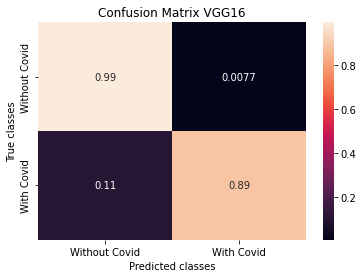

Accuracy:     0.934
Sensitivity:  0.992
Specificity:  0.891


In [60]:
# create a confusion matrix consisting of accuracy, sensitivity, and specificity. 
confusionMatrix =confusion_matrix(testY.argmax(axis=1),predict)
total = sum(sum(confusionMatrix))

# caculate accuracy, sensitivity, and specificity
accuracy = (confusionMatrix[0,0] + confusionMatrix[1,1]) / total
sensitivity = confusionMatrix[0,0] / (confusionMatrix[0,0] + confusionMatrix[0,1])
specificity = confusionMatrix[1,1] / (confusionMatrix[1,0] + confusionMatrix[1,1])

# plot confusion matrix
confusionMatrix = confusion_matrix(testY.argmax(axis=1),predict, normalize = 'true')
sns.heatmap(confusionMatrix, annot=True)
plt.title('Confusion Matrix VGG16')
plt.ylabel('True classes')
plt.xlabel('Predicted classes')
plt.xticks([0.5, 1.5], ['Without Covid', 'With Covid'])
plt.yticks([0.5, 1.5], ['Without Covid', 'With Covid'])
plt.show()

# display the output
print("Accuracy:    ", round(accuracy,3))
print("Sensitivity: ", round(sensitivity,3))
print("Specificity: ", round(specificity,3))

Plotting Accuracy and Loss

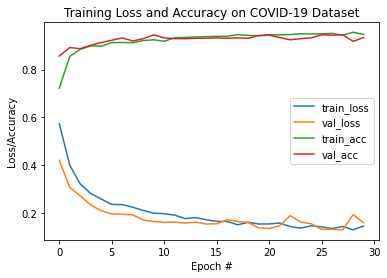

In [61]:
# graph for visual representation
plt.plot(np.arange(0, EPOCHS), head.history["loss"], label="train_loss")
plt.plot(np.arange(0, EPOCHS), head.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, EPOCHS), head.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, EPOCHS), head.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy on COVID-19 Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="center right")
plt.show()

# ResNet50 Model

In [62]:
# load the base model 
base_model = ResNet50(weights='imagenet', include_top=False,input_tensor=Input(shape=(LENGTH,WIDTH,3)))

94781440/94765736 [==============================] - 2s 0us/step


In [63]:
# create the head of the model that is going to be on top of the base model
head_model = base_model.output
head_model = AveragePooling2D(pool_size=(4,4))(head_model)
head_model = Flatten(name='flatten')(head_model)
head_model = Dense(64, activation='relu')(head_model)
head_model = Dropout(0.5)(head_model)
head_model = Dense(2, activation='softmax')(head_model)

In [64]:
# now we will create our model; this model will be the one that is used to do the trainings
model = Model(inputs=base_model.input, outputs=head_model)

In [65]:
# freeze the layers of the base model so its not updated during the first training process
for y in base_model.layers:
    y.trainable = False

In [66]:
# compile the model, same optimizer as VGG16
model.compile(
    optimizer = optimizer,
    loss = 'binary_crossentropy',
    metrics = ['accuracy']
)

In [67]:
# train the head of the network
head = model.fit(
    train_augment_bis.flow(trainX,trainY,batch_size=BATCH_SIZE),
    steps_per_epoch = len(trainX)//BATCH_SIZE,
    validation_data = (testX,testY),
    validation_steps = len(testX) // BATCH_SIZE,
    epochs = EPOCHS
)

Epoch 1/30
77/77 [==============================] - 109s 1s/step - loss: 0.6872 - accuracy: 0.5713 - val_loss: 0.6711 - val_accuracy: 0.5784
Epoch 2/30
77/77 [==============================] - 109s 1s/step - loss: 0.6661 - accuracy: 0.5795 - val_loss: 0.6442 - val_accuracy: 0.5784
Epoch 3/30
77/77 [==============================] - 110s 1s/step - loss: 0.6513 - accuracy: 0.5783 - val_loss: 0.6198 - val_accuracy: 0.5784
Epoch 4/30
77/77 [==============================] - 112s 1s/step - loss: 0.6336 - accuracy: 0.5791 - val_loss: 0.6010 - val_accuracy: 0.5784
Epoch 5/30
77/77 [==============================] - 110s 1s/step - loss: 0.6170 - accuracy: 0.5799 - val_loss: 0.5835 - val_accuracy: 0.5784
Epoch 6/30
77/77 [==============================] - 105s 1s/step - loss: 0.6162 - accuracy: 0.5807 - val_loss: 0.5698 - val_accuracy: 0.5784
Epoch 7/30
77/77 [==============================] - 105s 1s/step - loss: 0.6107 - accuracy: 0.5791 - val_loss: 0.5616 - val_accuracy: 0.5784
Epoch 8/30
77

Making Predictions

In [76]:
# predicting using the trained model
predict = model.predict(testX,batch_size=BATCH_SIZE)
# for each image, find the index of the label corresponding with the largest predicted probability
predict = np.argmax(predict,axis=1)
# now represent the prediction in a nicely formatted classification report
print(classification_report(testY.argmax(axis=1),predict,target_names=lb.classes_))

              precision    recall  f1-score   support

    ./DATA/0       0.76      0.85      0.80       261
    ./DATA/1       0.88      0.80      0.84       358

    accuracy                           0.82       619
   macro avg       0.82      0.83      0.82       619
weighted avg       0.83      0.82      0.82       619



Confusion Matrix

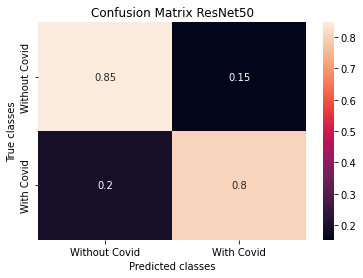

Accuracy:     0.822
Sensitivity:  0.847
Specificity:  0.804


In [77]:

# create a confusion matrix consisting of accuracy, sensitivity, and specificity. 
confusionMatrix =confusion_matrix(testY.argmax(axis=1),predict)
total = sum(sum(confusionMatrix))

# caculate accuracy, sensitivity, and specificity
accuracy = (confusionMatrix[0,0] + confusionMatrix[1,1]) / total
sensitivity = confusionMatrix[0,0] / (confusionMatrix[0,0] + confusionMatrix[0,1])
specificity = confusionMatrix[1,1] / (confusionMatrix[1,0] + confusionMatrix[1,1])

# plot confusion matrix
confusionMatrix = confusion_matrix(testY.argmax(axis=1),predict, normalize = 'true')
sns.heatmap(confusionMatrix, annot=True)
plt.title('Confusion Matrix ResNet50')
plt.ylabel('True classes')
plt.xlabel('Predicted classes')
plt.xticks([0.5, 1.5], ['Without Covid', 'With Covid'])
plt.yticks([0.5, 1.5], ['Without Covid', 'With Covid'])
plt.show()

# display the output
print("Accuracy:    ", round(accuracy,3))
print("Sensitivity: ", round(sensitivity,3))
print("Specificity: ", round(specificity,3))

Plot for Visual Representation

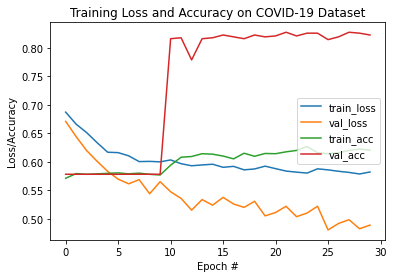

In [79]:
# graph for visual representation
plt.plot(np.arange(0, EPOCHS), head.history["loss"], label="train_loss")
plt.plot(np.arange(0, EPOCHS), head.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, EPOCHS), head.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, EPOCHS), head.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy on COVID-19 Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="center right")
plt.show()

# InceptionV3 Model

In [6]:
#load the pre-trained inception v3 model and weights making each base layer untrainable
pretrained_model = InceptionV3(input_shape=(LENGTH,WIDTH,3),
                               include_top = False,
                               weights="imagenet")
for layer in pretrained_model.layers:
  layer.trainable = False

In [11]:
#adding head layers for training on the new data with binary output
optimizer = Adam(learning_rate=INITIAL_LEARINGRATE, decay = INITIAL_LEARINGRATE/EPOCHS)
x = layers.AveragePooling2D(pool_size=(4,4))(pretrained_model.output)
x = layers.Flatten()(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(1,activation='sigmoid')(x)
model = Model(pretrained_model.input, x)
model.compile(optimizer = optimizer,
              loss = 'binary_crossentropy',
              metrics = ['acc'])


In [ ]:
# reload data to be single class
for x in image_path:
    # getting the classlabel
    label = x.split(os.path.sep)[-2]

    # now, we load the image, change the color to RGB and then resize it
    image = cv2.imread(x)
    image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    image = cv2.resize(image,(LENGTH,WIDTH))

    # update our label and data list
    labels.append(label)
    data.append(image)

# convert the data and labels to Numpy Arrays while scaling the pixel intensity
data = np.array(data) / 255.0 # 255 RGB colors
data.reshape(-1,1)
labels = np.array(labels)
data.shape

In [12]:
#80-20 train test split
trainX, testX, trainY, testY = train_test_split(data,labels,test_size=.2, stratify=labels,random_state=42)
trainY = trainY.astype(float)
testY = testY.astype(float)

In [13]:
#Fitting the model to the train data
head = model.fit(
    trainX,
    trainY,
    batch_size=BATCH_SIZE,
    steps_per_epoch = len(trainX)//BATCH_SIZE,
    validation_data = (testX,testY),
    validation_steps = len(testX) // BATCH_SIZE,
    epochs = EPOCHS
)

Epoch 1/30
77/77 [==============================] - 54s 670ms/step - loss: 0.4456 - acc: 0.8101 - val_loss: 0.2685 - val_acc: 0.8882
Epoch 2/30
77/77 [==============================] - 50s 656ms/step - loss: 0.2366 - acc: 0.9041 - val_loss: 0.2185 - val_acc: 0.8997
Epoch 3/30
77/77 [==============================] - 50s 649ms/step - loss: 0.1850 - acc: 0.9328 - val_loss: 0.1883 - val_acc: 0.9227
Epoch 4/30
77/77 [==============================] - 50s 652ms/step - loss: 0.1806 - acc: 0.9311 - val_loss: 0.1756 - val_acc: 0.9326
Epoch 5/30
77/77 [==============================] - 50s 657ms/step - loss: 0.1606 - acc: 0.9418 - val_loss: 0.1654 - val_acc: 0.9260
Epoch 6/30
77/77 [==============================] - 50s 655ms/step - loss: 0.1389 - acc: 0.9480 - val_loss: 0.1661 - val_acc: 0.9359
Epoch 7/30
77/77 [==============================] - 50s 653ms/step - loss: 0.1362 - acc: 0.9496 - val_loss: 0.1708 - val_acc: 0.9326
Epoch 8/30
77/77 [==============================] - 50s 652ms/step - 

In [14]:
predict = model.predict(testX,batch_size=BATCH_SIZE)
predict = np.round(predict)
print(classification_report(testY,predict))

              precision    recall  f1-score   support

         0.0       0.91      0.93      0.92       261
         1.0       0.95      0.93      0.94       358

    accuracy                           0.93       619
   macro avg       0.93      0.93      0.93       619
weighted avg       0.93      0.93      0.93       619



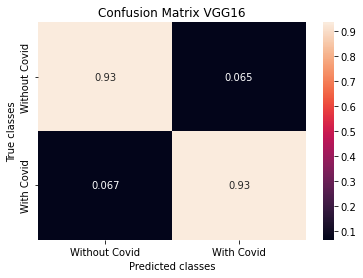

Accuracy:     0.934
Sensitivity:  0.935
Specificity:  0.933


In [15]:

# create a confusion matrix consisting of accuracy, sensitivity, and specificity. 
confusionMatrix =confusion_matrix(testY,predict)
total = sum(sum(confusionMatrix))

# caculate accuracy, sensitivity, and specificity
accuracy = (confusionMatrix[0,0] + confusionMatrix[1,1]) / total
sensitivity = confusionMatrix[0,0] / (confusionMatrix[0,0] + confusionMatrix[0,1])
specificity = confusionMatrix[1,1] / (confusionMatrix[1,0] + confusionMatrix[1,1])
# plot confusion matrix
confusionMatrix = confusion_matrix(testY,predict, normalize = 'true')
sns.heatmap(confusionMatrix, annot=True)
plt.title('Confusion Matrix VGG16')
plt.ylabel('True classes')
plt.xlabel('Predicted classes')
plt.xticks([0.5, 1.5], ['Without Covid', 'With Covid'])
plt.yticks([0.5, 1.5], ['Without Covid', 'With Covid'])
plt.show()

# display the output
print("Accuracy:    ", round(accuracy,3))
print("Sensitivity: ", round(sensitivity,3))
print("Specificity: ", round(specificity,3))

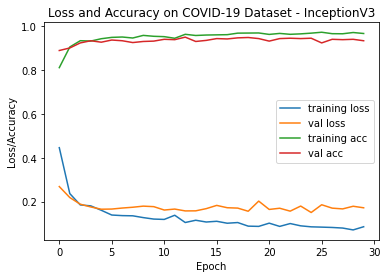

In [17]:
plt.plot(np.arange(0, EPOCHS), head.history['loss'], label='training loss')
plt.plot(np.arange(0, EPOCHS), head.history['val_loss'], label='val loss')
plt.plot(np.arange(0, EPOCHS), head.history['acc'], label='training acc')
plt.plot(np.arange(0, EPOCHS), head.history['val_acc'], label='val acc')
plt.title("Loss and Accuracy on COVID-19 Dataset - InceptionV3")
plt.xlabel("Epoch")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="center right")
plt.show()